In [1]:
from __future__ import division
import numpy as np
from graphviz import Source
from qnetwork import *
from utils import *
import matplotlib.pyplot as plt
from env import *
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def train(sess, env, qnet):
    
    global EXPLORATION_RATE
  
    summary_ops, summary_vars = build_summaries()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(SUMMARY_DIR, sess.graph)
    
    qnet.update_target()
    
    replay_buffer = ReplayBuffer(BUFFER_SIZE, RANDOM_SEED)
    
    for num_epi in range(MAX_EPISODES):

        s = env.reset()
        s = [list(np.unravel_index(s, env.shape))]

        ep_reward = 0
        ep_ave_max_q = 0

        for j in range(MAX_EPISODE_LEN):

            a = np.argmax(qnet.predict_q(np.reshape(s, (1, qnet.state_dim))))
    
            if np.random.rand(1) < EXPLORATION_RATE:
                s2, r, terminal, info = env.step(np.random.randint(0,qnet.action_dim))
            else:
                s2, r, terminal, info = env.step(a)
            
            s2 = list(np.unravel_index(s2, env.shape))

            replay_buffer.add(np.reshape(s, (qnet.state_dim,)), np.reshape(a, (1,)), r,
                              terminal, np.reshape(s2, (qnet.state_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > MINIBATCH_SIZE:
                s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)

                # Calculate targets
                target_q = qnet.predect_target(s2_batch)

                y_i = []
                for k in range(MINIBATCH_SIZE):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + GAMMA * np.amax(target_q[k]))

                # Update the critic given the targets
                predicted_q_value, _ = qnet.train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)), num_epi)

                ep_ave_max_q += np.amax(predicted_q_value)
                
                # Update target networks
                qnet.update_target()

            s = s2
            ep_reward += r

            if terminal or j == MAX_EPISODE_LEN-1:
                
                if EXPLORATION_RATE > 0.02 and terminal:
                    EXPLORATION_RATE = EXPLORATION_RATE*0.96

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j),
                    summary_vars[2]: EXPLORATION_RATE
                })

                writer.add_summary(summary_str, num_epi)
                writer.flush()

                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f} | Exploration: {:.6f} '.format(int(ep_reward), \
                        num_epi, (ep_ave_max_q / float(j)), EXPLORATION_RATE))
                
                f = open("stats.txt", "ab")
                f.write("| Reward: " + str(int(ep_reward)) 
                        +" | Episode: " + str(num_epi) 
                        + " | Qmax: " + str(ep_ave_max_q / float(j)) 
                        + " | Exploration: " + str(EXPLORATION_RATE) + "\n")
                f.close()
                
                break
                
        if num_epi%10 == 0:
            state_list = []
            action_list = []
            world = np.zeros(env.shape)
            for state in range(env.nS):
                state = np.unravel_index(state, env.shape)
                action = qnet.predict_q(np.reshape(state, (1,state_dim)))
                action = np.argmax(action)
                state_list.append(state)
                action_list.append(action)
                
#             print np.reshape(action_list, env.shape)
                
            f = open("action.txt","ab")
            act_string = np.array_str(np.reshape(action_list, env.shape))
            f.write(act_string)
            f.write("---------------------------\n")
            f.close()
    
    

In [3]:
LEARNING_RATE = 0.0015
GAMMA = 0.99
# GAMMA = 0.7
TAU = 0.001
BUFFER_SIZE = 10**6
MINIBATCH_SIZE = 64
RANDOM_SEED = 272
MAX_EPISODES = 50000
MAX_EPISODE_LEN = 3000
file_appendix = time.ctime()[4:16].replace("  ","").replace(" ","_").replace(":","-")
SUMMARY_DIR = './results/tf_ddqn_' + file_appendix
SAVE_DIR = "./saved_model/" + file_appendix + "/ddqn.ckpt"
EXPLORATION_RATE = 0.7

LTL = "<>(A && <>B) && []!C"

0
0


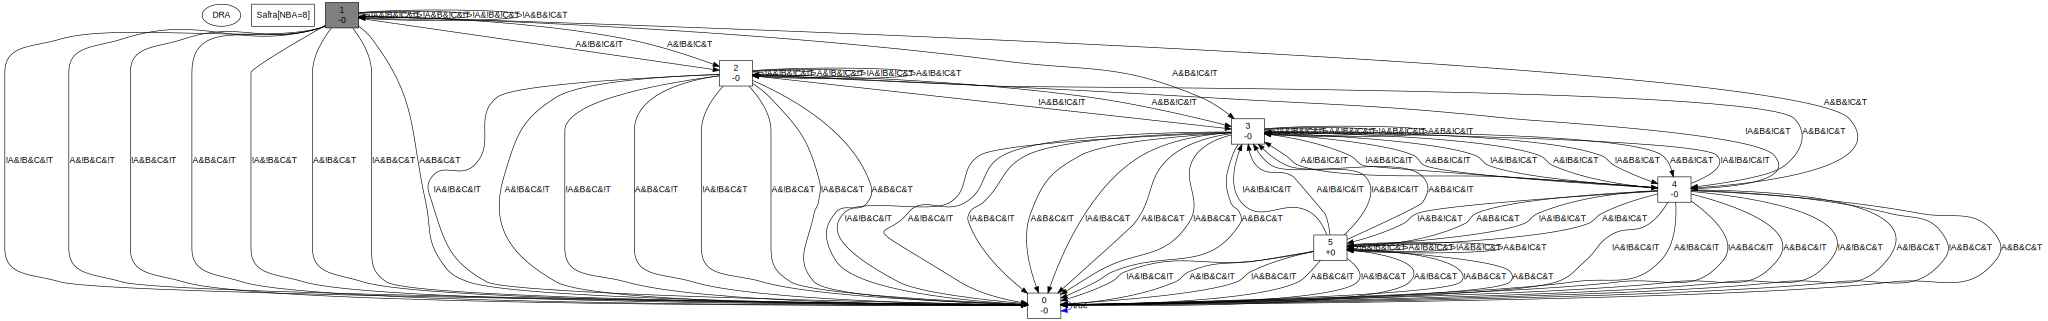

In [4]:
env = CurrentWorld(LTL)
with open("my.dot", "r") as dotfile:
    text = dotfile.read()
Source(text)

In [5]:
with tf.Session() as sess:
    
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    env.seed(RANDOM_SEED)
    
    state_dim = 3
    action_dim = 5
    
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    
    train(sess, env, Qnet)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


DDQN Saved
| Reward: -31710 | Episode: 0 | Qmax: 24.3418 | Exploration: 0.650000 
| Reward: -30810 | Episode: 1 | Qmax: 3.0091 | Exploration: 0.650000 
| Reward: -31080 | Episode: 2 | Qmax: -28.9442 | Exploration: 0.650000 
| Reward: -7780 | Episode: 3 | Qmax: -45.0250 | Exploration: 0.598000 
| Reward: -27780 | Episode: 4 | Qmax: -58.4124 | Exploration: 0.550160 
| Reward: -8920 | Episode: 5 | Qmax: -70.8828 | Exploration: 0.506147 
| Reward: -28550 | Episode: 6 | Qmax: -83.9471 | Exploration: 0.465655 
| Reward: -17810 | Episode: 7 | Qmax: -98.9696 | Exploration: 0.428403 
| Reward: -12320 | Episode: 8 | Qmax: -103.3625 | Exploration: 0.394131 
| Reward: -8340 | Episode: 9 | Qmax: -105.1896 | Exploration: 0.362600 
| Reward: -7510 | Episode: 10 | Qmax: -108.7276 | Exploration: 0.333592 
| Reward: -30000 | Episode: 11 | Qmax: -109.9412 | Exploration: 0.333592 
| Reward: -30000 | Episode: 12 | Qmax: -121.0268 | Exploration: 0.333592 
| Reward: -24990 | Episode: 13 | Qmax: -124.7749 | E

KeyboardInterrupt: 